In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns              

In [20]:
data = pd.read_csv("delivery_time.csv") 
data.head()

,Delivery Time,Sorting Time
0,21.00,10
1,13.50,4
2,19.75,6
3,24.00,9
4,29.00,10


# Performing EDA

### 1. Knowing general information and getting data ready

In [21]:
# data.shape               #it tells about no. of records and features
# data.columns             #determines column names
# data.dtypes              #checking data types
# data.isna().sum()        #checking --- is there any null value or not

In [22]:
data.info()               #gives information about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Delivery Time  21 non-null     float64
 1   Sorting Time   21 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 464.0 bytes


In [23]:
data[data.duplicated()].shape       #checking no. of duplicate records

(0, 2)

In [24]:
data.rename({'Delivery Time': 'deliverytime'}, axis=1,inplace=True)
data.rename({'Sorting Time': 'sortingtime'}, axis=1,inplace=True)

In [25]:
data.describe()                     #gives description about data

,deliverytime,sortingtime
count,21.000000,21.000000
mean,16.790952,6.190476
std,5.074901,2.542028
min,8.000000,2.000000
25%,13.500000,4.000000
50%,17.830000,6.000000
75%,19.750000,8.000000
max,29.000000,10.000000


### 2. data visualization

#### a) scatterplot

<AxesSubplot:xlabel='sortingtime', ylabel='deliverytime'>

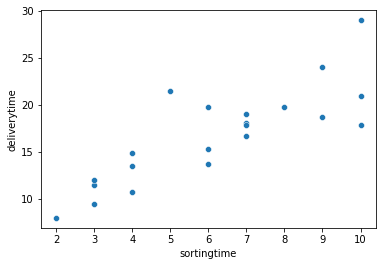

In [26]:
sns.scatterplot(x=data['sortingtime'],y = data['deliverytime'])    #data is scattered along a straight line (linear regression)

#### b) boxplot

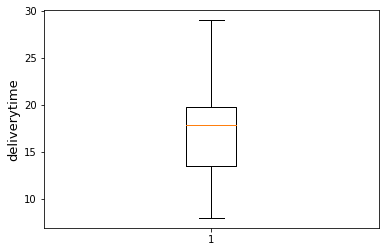

In [28]:
plt.ylabel("deliverytime", fontsize = 13 )                                         
box=plt.boxplot(x='deliverytime',data=data)      #checking outliers
                                                 #here no outlier and curve is right skewed and orange line denotes median

#### c-1) influential points using cook's distance (method 1)

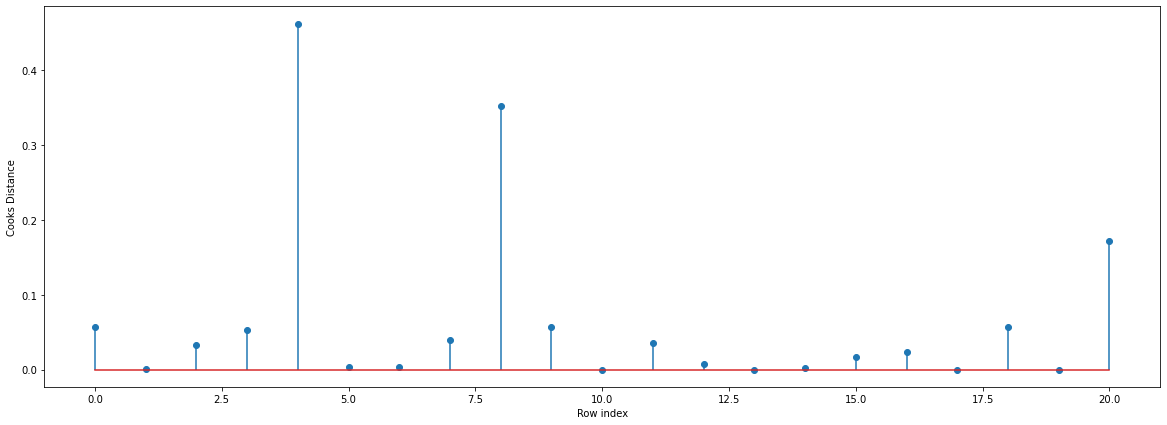

point having maximum cook's distance is : 


(4, 0.4620530412650319)

In [29]:
import statsmodels.formula.api as smf 
model = smf.ols('deliverytime~sortingtime',data=data).fit()

model_influence = model.get_influence()
(c , _) = model_influence.cooks_distance

fig = plt.subplots(figsize=(20, 7))
plt.stem(np.arange(len(data)), np.round(c, 3))
plt.xlabel('Row index')
plt.ylabel('Cooks Distance')
plt.show()

print("point having maximum cook's distance is : ")
(np.argmax(c),np.max(c))      #we got no influential point

#### c-2) influential points using bubble method (method 2)

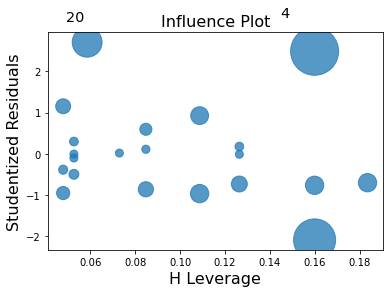

leverage_cutoff is :  0.42857142857142855


In [30]:
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(model)
plt.show()

k = data.shape[1]
n = data.shape[0]
leverage_cutoff = 3*((k + 1)/n)                               #k = no. of columns ; n = no. of records
print("leverage_cutoff is : ",leverage_cutoff)                #we got no influential point 
                                     #point having leverage value greater than leverage cutoff is actually a influential point

### 3. Correlation

In [35]:
data.corr()                    #if we got good correlation between x and y then we can go for model building
                               #note : x = sortingtime    y = delivery time

,deliverytime,sortingtime
deliverytime,1.000000,0.825997
sortingtime,0.825997,1.000000


#### a. heatmap

<AxesSubplot:>

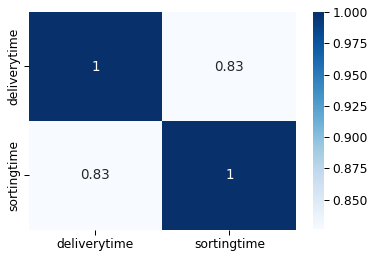

In [34]:
sns.set_context('paper', font_scale=1.4)
correlation = data.corr()

sns.heatmap(correlation, 
            annot=True, 
            cmap='Blues'
           )

# fitting of simple linear regression

### 1. ols method (using statmodels package)

#### a) building model

In [36]:
import statsmodels.formula.api as sms
model = sms.ols("deliverytime~sortingtime",data=data).fit()           #we cann't use y~x in case of ols method
print(model.summary())

#we get good value for R-squared
#
#null hypothesis : beta_1 (coeff. of sortingtime) = 0
#alternate hypothesis : beta_1 != 0
#p-low  null-go , hence null hypothesis rejected and alternate hypothesis accepted it means there is a relation between x and y
#note : x = sortingtime    y = delivery time

                            OLS Regression Results                            
Dep. Variable:           deliverytime   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     40.80
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           3.98e-06
Time:                        01:07:15   Log-Likelihood:                -51.357
No. Observations:                  21   AIC:                             106.7
Df Residuals:                      19   BIC:                             108.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.5827      1.722      3.823      

#### b) prediction for given data

   deliverytime  sortingtime  predicted_dtime
0         21.00           10        23.072933
1         13.50            4        13.178814
2         19.75            6        16.476853
3         24.00            9        21.423913
4         29.00           10        23.072933


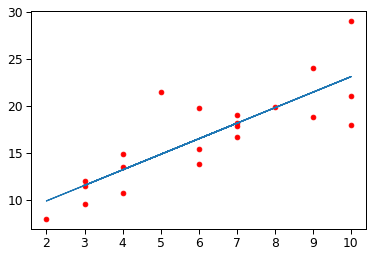

In [37]:
pred = model.predict(data["sortingtime"])
predicted_dtime = pd.Series(data = pred,name='predicted_dtime')

data1=pd.concat([data,predicted_dtime],axis=1)
print(data1.head())

plt.scatter(data["sortingtime"], data["deliverytime"], color='red')
plt.plot(data["sortingtime"],pred)

#### c) prediction for new value

In [38]:
value = float(input("enter sorting time for which you want to find delivery time : "))   #here float is used for ols method only
valueseries=pd.Series([value])
valuedf=pd.DataFrame(valueseries,columns=['sortingtime'])
valuedf

time=model.predict(valuedf)
print("delivery time for sorting time : ",value, "is : ",time)

enter sorting time for which you want to find delivery time : 8
delivery time for sorting time :  8.0 is :  0    19.774893
dtype: float64


### 2. LeaveOneOut Model Validation Technique

In [39]:
x = data.iloc[:, 1:2].values   #separating the dependent and independent features 
                               #[note: [:,0] -> column at index 0 in the form of row vector]
y = data.iloc[:, 0].values     #x - sorting time (independent); y - delivery time (dependent)
                               #[note:y's value row vector ki form m likhte h]

#### a) building model

In [40]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
loocv = LeaveOneOut()
loocv.get_n_splits(x)
print(loocv)
model = LinearRegression()
model.fit(x,y)
results = cross_val_score(model, x, y, cv=2)
print(results)
results.mean()*100.0

LeaveOneOut()
[0.63392505 0.55484248]


59.4383761394709

#### b) prediction for given data

   deliverytime  sortingtime  predicted_dtime
0         21.00           10        23.072933
1         13.50            4        13.178814
2         19.75            6        16.476853
3         24.00            9        21.423913
4         29.00           10        23.072933


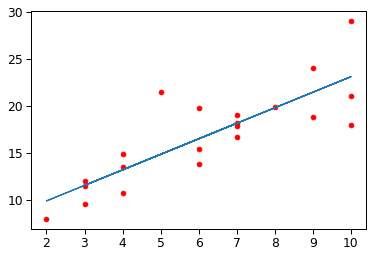

In [41]:
pred = model.predict(x)
predicted_dtime = pd.Series(data = pred,name='predicted_dtime')

data1=pd.concat([data,predicted_dtime],axis=1)
print(data1.head())

plt.scatter(x, y, color='red')
plt.plot(x,pred)

#### c) prediction for new value

In [42]:
value = input("enter sorting for which you want to find delivery time")
valueseries=pd.Series([value])
valuedf=pd.DataFrame(valueseries,columns=['sortingtime'])
valuedf

time=model.predict(valuedf)
print("delivery time for person having",value, "experience is : ",time)

enter sorting for which you want to find delivery time8
delivery time for person having 8 experience is :  [19.77489315]


### 3. KFold Model Validation Technique

In [43]:
x = data.iloc[:, 1:2].values   #separating the dependent and independent features 
                               #[note: [:,0] -> column at index 0 in the form of row vector]
y = data.iloc[:, 0].values     #x - sorting time (independent); y - delivery time (dependent)
                               #[note:y's value row vector ki form m likhte h]

#### a) building model

In [44]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
kfold = KFold(n_splits=5,shuffle=True, random_state=42)
model = LinearRegression()
model.fit(x,y)
results = cross_val_score(model, x, y, cv=kfold)           #we can also assign numeric value to cv
print(results)
results.mean()*100.0

[-1.02075996  0.79965647  0.42521191  0.47586105  0.96532833]


32.90595615670227

#### b) prediction for given data

   deliverytime  sortingtime  predicted_dtime
0         21.00           10        23.072933
1         13.50            4        13.178814
2         19.75            6        16.476853
3         24.00            9        21.423913
4         29.00           10        23.072933


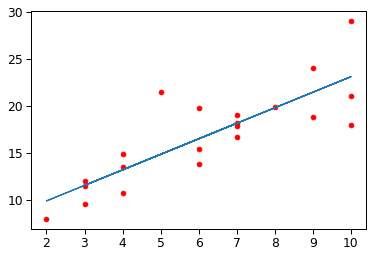

In [45]:
pred = model.predict(x)
predicted_dtime = pd.Series(data = pred,name='predicted_dtime')

data1=pd.concat([data,predicted_dtime],axis=1)
print(data1.head())

plt.scatter(x, y, color='red')
plt.plot(x,pred)

#### c) prediction for new value

In [46]:
value = input("enter sorting for which you want to find delivery time")
valueseries=pd.Series([value])
valuedf=pd.DataFrame(valueseries,columns=['sortingtime'])
valuedf

time=model.predict(valuedf)
print("delivery time for person having",value, "experience is : ",time)

enter sorting for which you want to find delivery time8
delivery time for person having 8 experience is :  [19.77489315]


### 4. train_test_split Model Validation Technique

In [47]:
x = data.iloc[:, 1:2].values   #separating the dependent and independent features 
                               #[note: [:,0] -> column at index 0 in the form of row vector]
y = data.iloc[:, 0].values     #x - sorting time (independent); y - delivery time (dependent)
                               #[note:y's value row vector ki form m likhte h]

#### a) building model

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20,random_state=7)
model = LinearRegression()
model.fit(X_train, Y_train)
result1 = model.score(X_train, Y_train)
result2 = model.score(X_test, Y_test)
print(result1)
print(result2)

0.6132975651849395
0.6682342232006111


#### b) prediction for given data

   deliverytime  sortingtime  predicted_dtime
0         21.00           10        22.748479
1         13.50            4        13.665902
2         19.75            6        16.693428
3         24.00            9        21.234716
4         29.00           10        22.748479


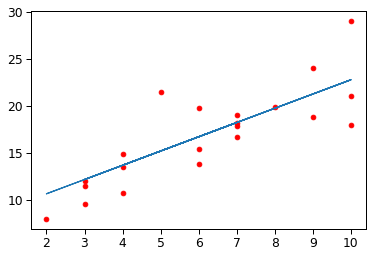

In [49]:
pred = model.predict(x)
predicted_dtime = pd.Series(data = pred,name='predicted_dtime')

data1=pd.concat([data,predicted_dtime],axis=1)
print(data1.head())

plt.scatter(x, y, color='red')
plt.plot(x,pred)

#### c) prediction for new value

In [50]:
value = input("enter sorting for which you want to find delivery time")
valueseries=pd.Series([value])
valuedf=pd.DataFrame(valueseries,columns=['sortingtime'])
valuedf

time=model.predict(valuedf)
print("delivery time for person having",value, "experience is : ",time)

enter sorting for which you want to find delivery time8
delivery time for person having 8 experience is :  [19.72095361]
